In [1]:
from numpy import *
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.special import *
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt
import warnings
import math

In [2]:
my_inf=1e6
def my_log(m):
    res = log(m, out=np.zeros_like(m), where=(m>0))
    return res
def return_arc_length(points, center, r):
    x1, y1 = points[0]
    x2, y2 = points[1]
    c_x, c_y = center
    # Calculate the distance between the center of the circle and the line segment
    dist = np.abs((y2 - y1) * c_x - (x2 - x1) * c_y + x2 * y1 - x1 * y2) / np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    # Check if the distance is less than or equal to the radius
    if dist < r:
        d = 2 * np.sqrt(r ** 2 - dist ** 2)
        l = 2*r*math.atan(d/math.sqrt(4*r**2-d**2+1e-8))
        return d,l
    else:
        return 0.0,0.0
class uav_flpo:
    def __init__(self,drones,stations,blocks=None,fcr=25,distance='euclidean') -> None:
        super().__init__()
        self.drones=drones
        self.stations=stations
        self.blocks=blocks
        self.N_drones= len(drones)
        self.N_stations=len(stations)
        self.stage_horizon=self.N_stations+1
        self.gamma_k_length=self.N_stations+1
        self.fcr=fcr
        self.distance=distance
        return

    def return_stagewise_cost(self,params,): #params is like stations
        d_F=cdist(params,params,self.distance)
        d_F=d_F+diag([my_inf]*self.N_stations)
        d_delta_to_f=array([my_inf]*self.N_stations).reshape(1,-1)
        d_df=np.concatenate((d_F,d_delta_to_f),axis=0)
        D_ss=[0]*self.N_drones
        for drone_id,drone in enumerate(self.drones):
            stage=concatenate((params,array(self.drones[drone_id][1]).reshape(1,-1)),axis=0)
            D_s=[0]*(self.stage_horizon+1)
            stage_0=array(self.drones[drone_id][0]).reshape(1,-1)
            D_s[0]=cdist(stage_0,stage,self.distance)
            if self.blocks is not None:
                print('add block cost here')
            D_s[0]=D_s[0]+0.5*my_inf*tanh(D_s[0]-self.drones[drone_id][2]*self.fcr)+0.5*my_inf

            #D_s[0][0,-1]=D_s[0][0,-1]*(D_s[0][0,-1]>my_inf)

            delta_id= self.N_stations+drone_id
            # so far we have taken care of the first distance matrix

            d_f_to_delta=cdist(params,array(self.drones[drone_id][1]).reshape(1,-1),self.distance)
            d_last=np.concatenate((d_f_to_delta,array([0]).reshape(1,-1)),axis=0)
            d=np.concatenate((d_df,d_last),axis=1)
            if self.blocks is not None:
                print('add block cost here')

            d=d+(0.5*my_inf*tanh(d-self.fcr)+0.5*my_inf)

            for i in range(1,self.stage_horizon):
                D_s[i]=d
            d_l=[my_inf]*(self.gamma_k_length-1)
            d_l.append(0.0)
            D_s[-1]=array(d_l).reshape(-1,1)
            D_ss[drone_id]=D_s
        self.D_ss=D_ss
        return
    def calc_associations(self,beta):
        p=[]
        self.return_stagewise_cost(self.params.reshape(-1,2))
        D_ss=self.D_ss

        for D_s in D_ss:

            K=len(D_s)
            D=D_s[::-1]
            out_D=[0]*(K+1)
            out_D[0]=array([0.0]).reshape(-1,1)
            out_p=[0]*(K+1)
            out_p[0]=array([1.0]).reshape(-1,1)
            out=[0]*(K+1)
            out[0]=array([1.0]).reshape(-1,1)
            for i in range(1,K+1):
                out_D[i]=(D[i-1]+repeat(transpose(out_D[i-1]),D[i-1].shape[0],axis=0))
                m=out_D[i].min(axis=1,keepdims=True)
                exp_D=exp(multiply(-beta,out_D[i]-m))
                out[i]=sum(multiply(exp_D,tile(out[i-1], (1,D[i-1].shape[0])).T),axis=1,keepdims=True)
                out_p[i]=divide(multiply(exp_D,out[i-1].T),out[i])
                out_D[i]=m
            p.append(out_p[::-1][:-1])
        self.P_ss=p
        return
    def free_energy(self,D_s,P_s,beta):
        '''
        input: D_s: a list of K numpy arrays corrosponding to distances between stages
        P_s: a list of K numpy arrays corrosponding to probabilities between stages

        output: out_c: K+1 numpy arrays with shape[1]=1, indicating the total cost of nodes
        '''

        K=len(D_s)
        D=D_s[::-1]
        P=P_s[::-1]
        out_P=[0]*(K+1)
        out_C=[0]*(K+1)
        out_H=[0]*(K+1)
        out_P[0]=array([1.0]).reshape(-1,1)
        out_C[0]=array([0.0]).reshape(-1,1)
        out_H[0]=array([0.0]).reshape(-1,1)
        for i in range(1,K+1):
          # assigning P of each node for calculating C in the next i
          out_P[i]=(P[i-1]*repeat(transpose(out_P[i-1]),P[i-1].shape[0],axis=0)).sum(axis=1).reshape(-1,1)
          out_C[i]=(P[i-1]*(D[i-1]*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)+repeat(transpose(out_C[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
          out_H[i]=-(P[i-1]*(my_log(P[i-1])*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)-repeat(transpose(out_H[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)

        # D-1/beta*H
        return (out_C[-1].T).sum() + (-1/beta)*(out_H[-1].T).sum()
    def objective(self,params,beta):
        self.return_stagewise_cost(params.reshape(-1,2))
        cost=0
        for i in range(len(self.D_ss)):
            cost+=self.free_energy(self.D_ss[i],self.P_ss[i],beta)
        return cost
    def optimize_D(self,init_guess,beta,method):
        result = minimize(self.objective, init_guess,args=(beta,),method=method)
        self.params = result.x
        self.cost_fun=result.fun
    def calc_routs(self):
        O=[]
        for i in range(self.N_drones):
          m=0
          o=[]
          for p in self.P_ss[i]:
              m=argmax(p[m,:])
              o.append(m)
          o.pop()
          O.append(o)
        self.routs=O

    def train(self,beta_init=1e-6,beta_f=100,alpha=1.5,purturb=0.1,method='nelder-mead',verbos=0):
        self.Y_s=[]
        self.Betas=[]
        self.params=ndarray.flatten(self.stations)
        beta=beta_init
        init_guess=self.params
        while beta <= beta_f:
            count=0
            self.params=self.params+random.normal(0, purturb, self.params.shape)
            while True:
                self.calc_associations(beta) #based on D_ss
                #init_guess_d=init_guess+random.normal(0, 0.01, init_guess.shape)
                self.optimize_D(init_guess,beta,method=method) #based on P_ss
                #print(self.params)
                if linalg.norm(self.params-init_guess)/linalg.norm(init_guess) <=1e-4:
                  break
                init_guess=self.params
                count+=1

            if verbos:
              print(f'Beta: {beta:.4e}  epoches: {count} F.E.: {self.cost_fun:0.5e}')
            beta=beta*alpha
            self.Y_s.append(self.params.reshape(-1,2))
            self.Betas.append(beta)
        self.calc_routs()

    def print_routs(self):
        print("")
        for i,o in enumerate(self.routs):
          print(f'\nDrone{i+1} --->', end='')
          for j in o:
            if j<env.N_stations:
              print(f'f{j+1} --->', end='')
            else:
              print(f'[D{i+1}]', end='')

    def plot_routs(self):
        state_locs=self.params.reshape(-1,2)
        drone_locs=array([i[0] for i in self.drones])
        dest_locs=array([i[1] for i in self.drones])
        plt.scatter(drone_locs[:,0],drone_locs[:,1],color='black',label='Drone locations')
        for i, loc in enumerate(drone_locs):
            plt.text(loc[0], loc[1], 'V'+str(i+1)+f' ({self.drones[i][2]*100}%)', ha='center', va='bottom')
        plt.scatter(state_locs[:,0],state_locs[:,1],marker='^',label='Station locations')
        for i, loc in enumerate(state_locs):
            plt.text(loc[0], loc[1], 'F'+str(i+1), ha='center', va='bottom')
        plt.scatter(dest_locs[:,0],dest_locs[:,1],marker='*',label='Destinations')
        for i, loc in enumerate(dest_locs):
            plt.text(loc[0]+2*random.rand()*(-1)**round(random.rand()), loc[1]+2*random.rand(), 'D'+str(i+1), ha='center', va='bottom')
        options = ['-', '--', '-.', ':',]
        for i, o in enumerate(self.routs):
            line_style=random.choice(options)
            drone_loc = drone_locs[i]
            try:
              state_loc = state_locs[o[0]]
            except:
              state_loc=dest_locs[i]
            color=random.rand(3)
            # Draw a line between drone_loc and state_loc
            plt.plot([drone_loc[0], state_loc[0]], [drone_loc[1], state_loc[1]], color=color,linewidth=1.5,linestyle=line_style)
            dist = np.sqrt(np.sum((drone_loc - state_loc) ** 2))
            col='red' if dist > self.drones[i][2]*self.fcr else 'green'
            if dist >0.0:
              plt.text((drone_loc[0] + state_loc[0]) / 2, (drone_loc[1] + state_loc[1]) / 2, f'{dist:.0f}', color=col, ha='center')
            # Draw lines between each two elements in o
            if len(o)>1:
              for j in range(len(o) - 1):
                  try:
                    loc1 = state_locs[o[j]]
                  except:
                    loc1 = dest_locs[i]
                  try:
                    loc2 = state_locs[o[j + 1]]
                  except:
                    loc2=dest_locs[i]
                  # Draw a line between loc1 and loc2
                  plt.plot([loc1[0], loc2[0]], [loc1[1], loc2[1]], color=color,linewidth=1.5,linestyle=line_style)
                  dist = np.sqrt(np.sum((loc1 - loc2) ** 2))
                  col='red' if dist > self.fcr else 'green'
                  if dist>0.0:
                    plt.text((loc1[0] + loc2[0]) / 2, (loc1[1] + loc2[1]) / 2, f'{dist:.0f}', color=col, ha='center')
        # Set axis labels and legend
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.title(f'Drone FLPO (F.C.R. = {self.fcr})')
        # Display the plot
        plt.show()

In [6]:
# a list of drones, each element containing two tuples,
# representing the coordinates of the initial deployment position
# the destination coordinates, and initial charge respectively
drones=[((35.0,32),(10.0,30),1.0),
        ((40.0,15),(8.0,3),0.99),
        ((20.0,4),(22.0,20),1.0),
        ((6.0,20),(38.0,22),1.0)]
# a list of initial guess of charging stations, could be random. the size of
# the list determines the number of charging stations

stations=array([[20.0,20.0],
          [20.0,20.0],
          [20.0,20.0],
])

blocks=[((10.0,10),5.0)],
env=uav_flpo(drones,stations,blocks=None,fcr=25.0,distance='euclidean')
env.train(beta_init=1e-8,beta_f=100,alpha=1.5,
          purturb=0.1,method='nelder-mead',verbos=1)


Beta: 1.0000e-08  epoches: 2 F.E.: -2.20550e+09
Beta: 1.5000e-08  epoches: 0 F.E.: -1.46617e+09
Beta: 2.2500e-08  epoches: 0 F.E.: -9.73308e+08
Beta: 3.3750e-08  epoches: 0 F.E.: -6.44771e+08
Beta: 5.0625e-08  epoches: 0 F.E.: -4.25802e+08
Beta: 7.5938e-08  epoches: 0 F.E.: -2.79906e+08
Beta: 1.1391e-07  epoches: 0 F.E.: -1.82765e+08
Beta: 1.7086e-07  epoches: 1 F.E.: -1.18188e+08
Beta: 2.5629e-07  epoches: 0 F.E.: -7.54070e+07
Beta: 3.8443e-07  epoches: 0 F.E.: -4.72770e+07
Beta: 5.7665e-07  epoches: 0 F.E.: -2.90666e+07
Beta: 8.6498e-07  epoches: 1 F.E.: -1.76163e+07
Beta: 1.2975e-06  epoches: 2 F.E.: -1.07113e+07
Beta: 1.9462e-06  epoches: 1 F.E.: -6.67130e+06
Beta: 2.9193e-06  epoches: 4 F.E.: -4.27901e+06
Beta: 4.3789e-06  epoches: 2 F.E.: -2.80581e+06
Beta: 6.5684e-06  epoches: 1 F.E.: -1.86213e+06
Beta: 9.8526e-06  epoches: 0 F.E.: -1.24061e+06
Beta: 1.4779e-05  epoches: 0 F.E.: -8.26976e+05
Beta: 2.2168e-05  epoches: 0 F.E.: -5.51253e+05
Beta: 3.3253e-05  epoches: 0 F.E.: -3.67



Drone1 --->f3 --->[D1][D1][D1]
Drone2 --->f2 --->[D2][D2][D2]
Drone3 --->[D3][D3][D3][D3]
Drone4 --->f1 --->[D4][D4][D4]

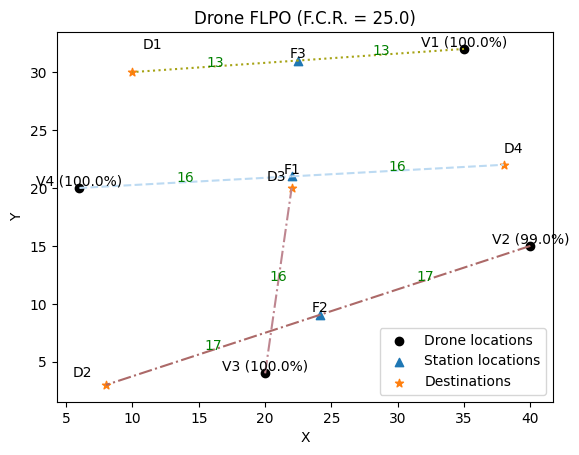

In [7]:
env.print_routs()
env.plot_routs()

In [8]:
def return_arc_length(points, center, r):
    x1, y1 = points[0]
    x2, y2 = points[1]
    c_x, c_y = center
    # Calculate the distance between the center of the circle and the line segment
    dist = np.abs((y2 - y1) * c_x - (x2 - x1) * c_y + x2 * y1 - x1 * y2) / np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    # Check if the distance is less than or equal to the radius
    if dist < r:
        d = 2 * np.sqrt(r ** 2 - dist ** 2)
        l = 2*r*math.atan(d/math.sqrt(4*r**2-d**2+1e-8))
        return d,l
    else:
        return 0.0,0.0

# Example usage
x1, y1 = 1, 1
x2, y2 = 4, 4
c_x, c_y = 2, 2
r = 1

points = [(x1, y1), (x2, y2)]
center = (c_x, c_y)

length = return_arc_length(points, center, r)

print(f"Arc length: {length[1]:.2f}")



Arc length: 3.14
